In [204]:
import os
import json
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

plt.rcParams.update({'font.size': 20})

def linear_fit(x, y):
    x_ = x - x.mean()
    y_ = y - y.mean()
    k = (x_ * y_).sum() / (x_ * x_).sum()
    b = y.mean() - k * x.mean()
    return k, b

IMAGE_DIR = 'images/convnet-cifar100/'
os.makedirs(IMAGE_DIR, exist_ok=True)

## Fixed ELR

In [205]:
general_path = '../experiments/convnet16_cifar100_50000obj_ce/fixed_elr/'

dirs = os.listdir(general_path)
lrs, wds = [], []
for directory in dirs:
    with open(os.path.join(general_path, directory, 'config.json')) as f:
        config = json.load(f)
        #if config['lr'] < 0.02:
        lrs.append(config['lr'])
        wds.append(config['wd'])

lrs = np.unique(lrs)
wds = np.unique(wds)
wd_colors = sns.color_palette('viridis', len(wds))
lr_colors = sns.color_palette('plasma', len(lrs))

In [206]:
log_iters = np.array(config['log_iters'])
shape = (len(lrs), len(wds), len(log_iters))
train_losses = np.zeros(shape)
stoch_grad_rms = np.zeros(shape)
full_grad_norms = np.zeros(shape)
spherical_entropies = np.zeros(shape)
log_radii = np.zeros(shape)
mean_radii = np.zeros(shape)

for i, lr in enumerate(lrs):
    for j, wd in enumerate(wds):
        path = general_path+f'lr{lr:.2e}_wd{wd:.2e}_seed1/trace.pt'
        trace = torch.load(path, map_location=torch.device('cpu'), weights_only=False)
        try:
            train_losses[i, j] = np.array(trace['trace']['train_loss'])
            stoch_grad_rms[i, j] = np.array(trace['trace']['stoch_grad_rms'])
            full_grad_norms[i, j] = np.array(trace['trace']['full_grad_norm'])
            spherical_entropies[i, j] = np.array(trace['trace']['spherical_entropy'])
            log_radii[i, j] = np.array(trace['trace']['log_radius'])
            mean_radii[i, j] = np.array(trace['trace']['mean_radius'])
        except:
            print(f'No checkpoint for LR={lr:.2e}, WD={wd:.2e}')

full_entropies = spherical_entropies + log_radii
covariance_traces = stoch_grad_rms ** 2 * mean_radii ** 2
full_gn_sq = full_grad_norms ** 2 * mean_radii ** 2

In [207]:
D = 0
for key, param in trace['model'].items():
    if 'conv_layers' in key and 'weight' in key:
        D += param.numel()
D

97200

In [208]:
num_logs_to_avg = 30
U = train_losses[..., -num_logs_to_avg:].mean(-1)
S_sphere = spherical_entropies[..., -num_logs_to_avg:].mean(-1)
S_full = full_entropies[..., -num_logs_to_avg:].mean(-1)
r = mean_radii[..., -num_logs_to_avg:].mean(-1)
V = 0.5 * r ** 2
tr_Sigma = covariance_traces[..., -num_logs_to_avg:].mean(-1)
sigma_sq = tr_Sigma / (D - 1)
full_gn_sq = full_gn_sq[..., -num_logs_to_avg:].mean(-1)
T = lrs.reshape(-1, 1) * sigma_sq / 2

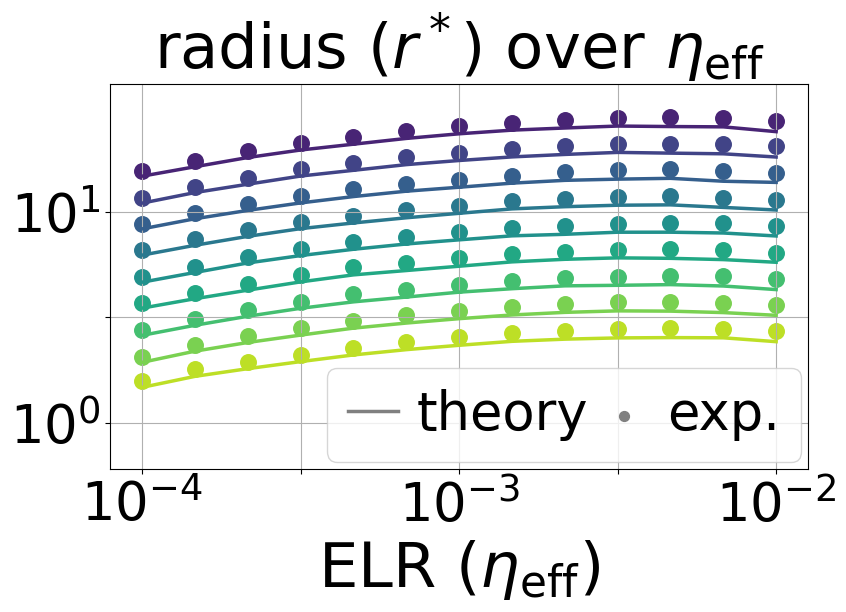

In [209]:
plt.figure(figsize=(9, 5))
plt.tight_layout()

for i in range(len(wds)):
    wd = wds[i]
    pred_rs = (T[:, i] * (D - 1) / wd) ** 0.5
    plt.scatter(lrs, r[:, i], color=wd_colors[i], marker='.', s=500)
    plt.plot(lrs, pred_rs, color=wd_colors[i], linestyle='-', linewidth=2.5)

plt.plot([], [], linestyle='-', color='gray', label=r'theory', linewidth=2.5)
plt.scatter([], [], color='gray', marker='.', label='exp.', s=200)
plt.xscale('log')
plt.yscale('log')
plt.xticks([1e-4, 10 ** -3.5, 1e-3, 10 ** -2.5, 1e-2], ['$10^{-4}$', '', '$10^{-3}$', '', '$10^{-2}$'], fontsize=38)
plt.xticks([], [], minor=True)
plt.yticks([1, 10 ** 0.5, 10], ['$10^{0}$', '', '$10^{1}$'], fontsize=38)
plt.yticks([], [], minor=True)
plt.ylim(6e-1, 40)
plt.xlabel(r'ELR ($\eta_{\text{eff}}$)', fontsize=45)
plt.title(r'radius ($r^*$) over $\eta_{\text{eff}}$', fontsize=45, y=1.02)
plt.legend(ncol=2, fontsize=38, loc=(0.31, 0.02),
           columnspacing=0.2, handletextpad=0.35, labelspacing=0.2, handlelength=0.95)
plt.grid()
plt.savefig(f'{IMAGE_DIR}ELR-radius.png', dpi=400, bbox_inches='tight')

<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:23: SyntaxWarning: invalid escape sequence '\l'
/var/folders/03/wmtcyjrj71bgyd6ps5fk0hdh0000gn/T/ipykernel_7471/2748780842.py:23: SyntaxWarning: invalid escape sequence '\l'
  leg = plt.legend(ncol=1, title='WD ($\lambda$)', fontsize=32, loc=(1.01, 0.05),


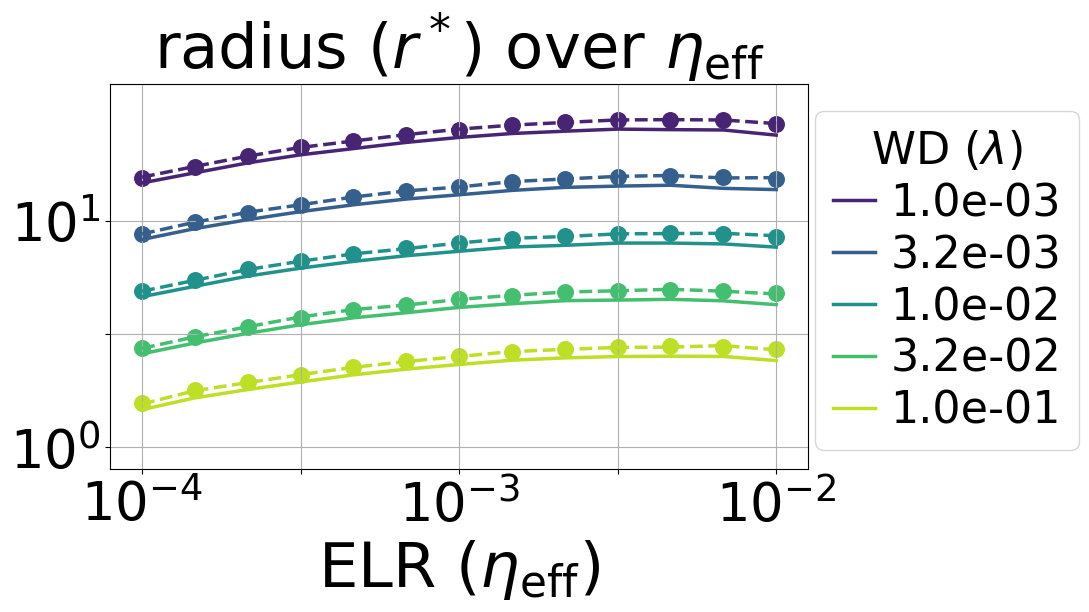

In [191]:
plt.figure(figsize=(9, 5))
plt.tight_layout()

for i in range(0, len(wds), 2):
    wd = wds[i]
    pred_rs = (T[:, i] * (D - 1) / wd) ** 0.5
    discr_pred_rs = (lrs * (tr_Sigma[:, i] + full_gn_sq[:, i]) / (2 * wd)) ** 0.5
    plt.scatter(lrs, r[:, i], color=wd_colors[i], marker='.', s=500)
    plt.plot(lrs, pred_rs, color=wd_colors[i], linestyle='-', linewidth=2.5, label=f'{wd:.1e}')
    plt.plot(lrs, discr_pred_rs, color=wd_colors[i], linestyle='--', linewidth=2.5)

#plt.plot([], [], linestyle='-', color='gray', label=r'theory', linewidth=2.5)
#plt.scatter([], [], color='gray', marker='.', label='exp.', s=200)
plt.xscale('log')
plt.yscale('log')
plt.xticks([1e-4, 10 ** -3.5, 1e-3, 10 ** -2.5, 1e-2], ['$10^{-4}$', '', '$10^{-3}$', '', '$10^{-2}$'], fontsize=38)
plt.xticks([], [], minor=True)
plt.yticks([1, 10 ** 0.5, 10], ['$10^{0}$', '', '$10^{1}$'], fontsize=38)
plt.yticks([], [], minor=True)
plt.ylim(8e-1, 40)
plt.xlabel(r'ELR ($\eta_{\text{eff}}$)', fontsize=45)
plt.title(r'radius ($r^*$) over $\eta_{\text{eff}}$', fontsize=45, y=1.02)
leg = plt.legend(ncol=1, title='WD ($\lambda$)', fontsize=32, loc=(1.01, 0.05),
           columnspacing=0.2, handletextpad=0.35, labelspacing=0.2, handlelength=0.95)
plt.setp(leg.get_title(),fontsize=32)
plt.grid()
plt.savefig(f'{IMAGE_DIR}ELR-discr-radius.png', dpi=400, bbox_inches='tight')

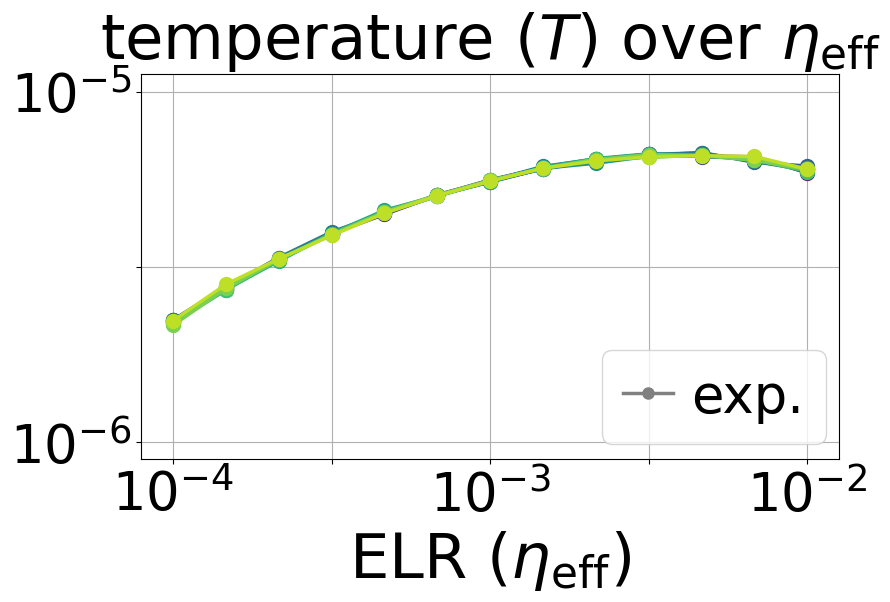

In [192]:
plt.figure(figsize=(9, 5))
plt.tight_layout()

for i in range(len(wds)):
    wd = wds[i]
    plt.plot(lrs, T[:, i], color=wd_colors[i], marker='o', markersize=10, linestyle='-', linewidth=2.5)

plt.plot([], [], linestyle='-', marker='o', markersize=8, color='gray', label=r'exp.', linewidth=2.5)
plt.xscale('log')
plt.yscale('log')
plt.xticks([1e-4, 10 ** -3.5, 1e-3, 10 ** -2.5, 1e-2], ['$10^{-4}$', '', '$10^{-3}$', '', '$10^{-2}$'], fontsize=38)
plt.xticks([], [], minor=True)
plt.yticks([10 ** -6, 10 ** -5.5, 10 ** -5], ['$10^{-6}$', '', '$10^{-5}$'], fontsize=38)
plt.yticks([], [], minor=True)
plt.ylim(10 ** -6.05, 10 ** -4.95)
plt.xlabel(r'ELR ($\eta_{\text{eff}}$)', fontsize=45)
plt.title(r'temperature ($T$) over $\eta_{\text{eff}}$', fontsize=45, y=1.02)
plt.legend(ncol=2, fontsize=38, loc=(0.66, 0.04),
           columnspacing=0.2, handletextpad=0.35, labelspacing=0.2, handlelength=0.95)
plt.grid()
plt.savefig(f'{IMAGE_DIR}ELR-temp.png', dpi=400, bbox_inches='tight')

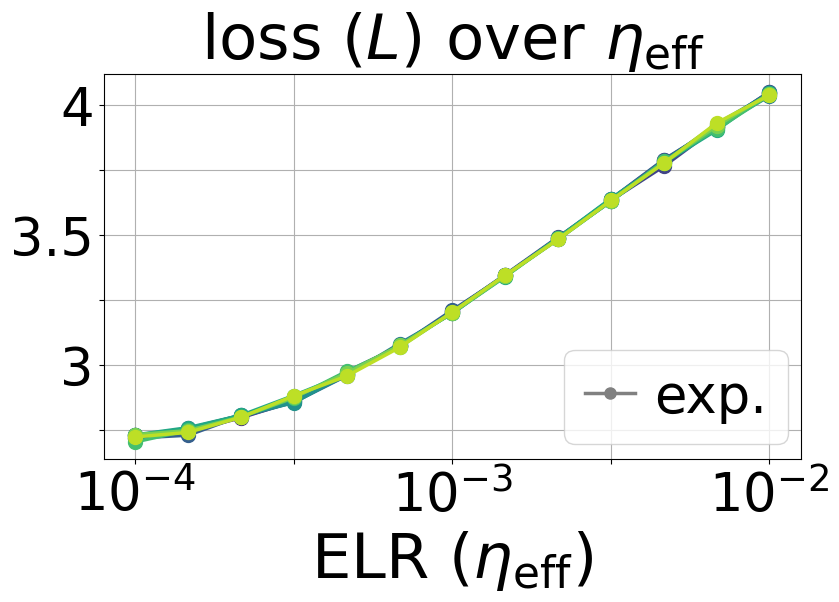

In [193]:
plt.figure(figsize=(9, 5))
plt.tight_layout()

for i in range(len(wds)):
    wd = wds[i]
    plt.plot(lrs, U[:, i], color=wd_colors[i], marker='o', markersize=10, linestyle='-', linewidth=2.5)

plt.plot([], [], linestyle='-', marker='o', markersize=8, color='gray', label=r'exp.', linewidth=2.5)
plt.xscale('log')
#plt.yscale('log')
plt.xticks([1e-4, 10 ** -3.5, 1e-3, 10 ** -2.5, 1e-2], ['$10^{-4}$', '', '$10^{-3}$', '', '$10^{-2}$'], fontsize=38)
plt.xticks([], [], minor=True)
plt.yticks([2.75, 3, 3.25, 3.5, 3.75, 4], ['', 3, '', 3.5, '', 4], fontsize=38)
plt.yticks([], [], minor=True)
#plt.ylim(10 ** -0.55, 10 ** 0.3)
plt.xlabel(r'ELR ($\eta_{\text{eff}}$)', fontsize=45)
plt.title(r'loss ($L$) over $\eta_{\text{eff}}$', fontsize=45, y=1.02)
plt.legend(ncol=2, fontsize=38, loc=(0.66, 0.04),
           columnspacing=0.2, handletextpad=0.35, labelspacing=0.2, handlelength=0.95)
plt.grid()
plt.savefig(f'{IMAGE_DIR}ELR-loss.png', dpi=400, bbox_inches='tight')

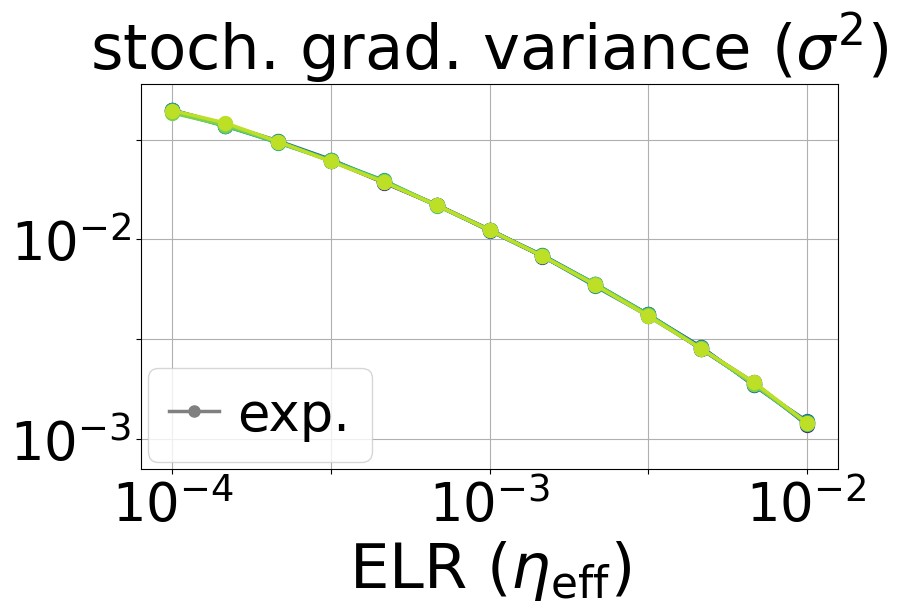

In [194]:
plt.figure(figsize=(9, 5))
plt.tight_layout()

for i in range(len(wds)):
    wd = wds[i]
    plt.plot(lrs, sigma_sq[:, i], color=wd_colors[i], marker='o', markersize=10, linestyle='-', linewidth=2.5)

plt.plot([], [], linestyle='-', marker='o', markersize=8, color='gray', label=r'exp.', linewidth=2.5)
plt.xscale('log')
plt.yscale('log')
plt.xticks([1e-4, 10 ** -3.5, 1e-3, 10 ** -2.5, 1e-2], ['$10^{-4}$', '', '$10^{-3}$', '', '$10^{-2}$'], fontsize=38)
plt.xticks([], [], minor=True)
plt.yticks([10 ** -3, 10 ** -2.5, 10 ** -2, 10 ** -1.5], ['$10^{-3}$', '', '$10^{-2}$', ''], fontsize=38)
plt.yticks([], [], minor=True)
plt.ylim(7e-4, 6e-2)
plt.xlabel(r'ELR ($\eta_{\text{eff}}$)', fontsize=45)
plt.title(r'stoch. grad. variance ($\sigma^2$)', fontsize=45, y=1.02)
plt.legend(ncol=2, fontsize=38, loc=(0.01, 0.02),
           columnspacing=0.2, handletextpad=0.35, labelspacing=0.2, handlelength=0.95)

plt.grid()
plt.savefig(f'{IMAGE_DIR}ELR-sigma.png', dpi=400, bbox_inches='tight')

In [210]:
log_lrs_ = np.tile(np.log(lrs).reshape(-1, 1), (1, len(wds))).reshape(-1)
log_wds_ = np.tile(np.log(wds).reshape(1, -1), (len(lrs), 1)).reshape(-1)
X = np.stack([
    log_lrs_, log_wds_, log_lrs_ ** 2, log_wds_ ** 2, log_lrs_ * log_wds_
], axis=1)

lin_regr = LinearRegression().fit(X, S_full.reshape(-1))
S_smoothed = lin_regr.predict(X).reshape(len(lrs), len(wds))
coefs = np.concatenate([np.array([lin_regr.intercept_]), lin_regr.coef_])
f'R^2 of approximation: {r2_score(S_full.reshape(-1), S_smoothed.reshape(-1)):.5f}'

'R^2 of approximation: 0.97912'

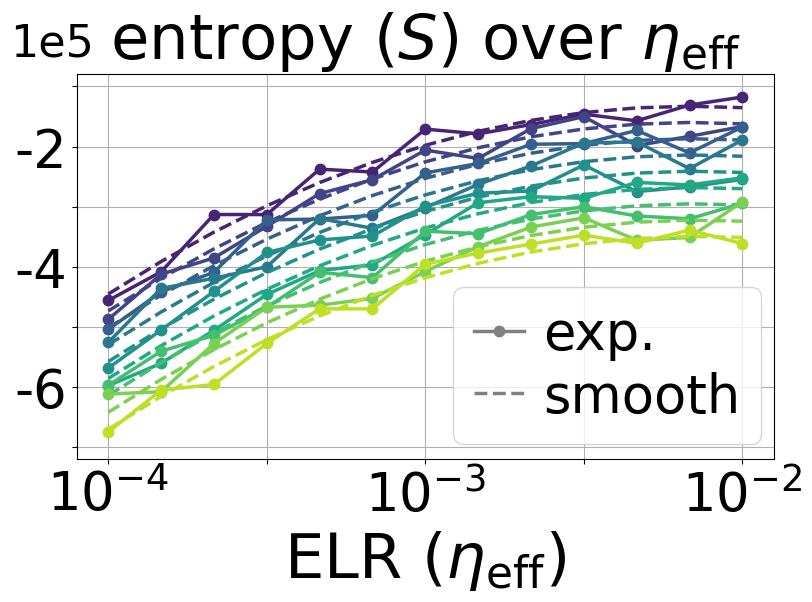

In [211]:
plt.figure(figsize=(9, 5))
plt.tight_layout()

for i in range(len(wds)):
    plt.plot(lrs, S_full[:, i], color=wd_colors[i], marker='.', markersize=15, linestyle='-', linewidth=2.5)
    plt.plot(lrs, S_smoothed[:, i], color=wd_colors[i], linestyle='--', linewidth=2.5)

plt.plot([], [], linestyle='-', marker='.', color='gray', label=r'exp.', markersize=15, linewidth=2.5)
plt.plot([], [], color='gray', label='smooth', linestyle='--', linewidth=2.5)
plt.xscale('log')
#plt.yscale('log')
plt.xticks([1e-4, 10 ** -3.5, 1e-3, 10 ** -2.5, 1e-2], ['$10^{-4}$', '', '$10^{-3}$', '', '$10^{-2}$'], fontsize=38)
plt.xticks([], [], minor=True)
plt.yticks([-7e5, -6e5, -5e5, -4e5, -3e5, -2e5, -1e5], ['', '-6', '', '-4', '', '-2', ''], fontsize=38)
plt.annotate(xy=(10**-4.31, -0.5e5), text=r'1e5', fontsize=32, annotation_clip=False)
plt.yticks([], [], minor=True)
plt.ylim(-7.2e5, -0.8e5)
plt.xlabel(r'ELR ($\eta_{\text{eff}}$)', fontsize=45)
plt.title(r'entropy ($S$) over $\eta_{\text{eff}}$', fontsize=45, y=1.02)
plt.legend(ncol=1, fontsize=38, loc=(0.54, 0.04),
           columnspacing=0.2, handletextpad=0.35, labelspacing=0.2, handlelength=0.95)
plt.grid()
plt.savefig(f'{IMAGE_DIR}ELR-entropy-LR.png', dpi=400, bbox_inches='tight')

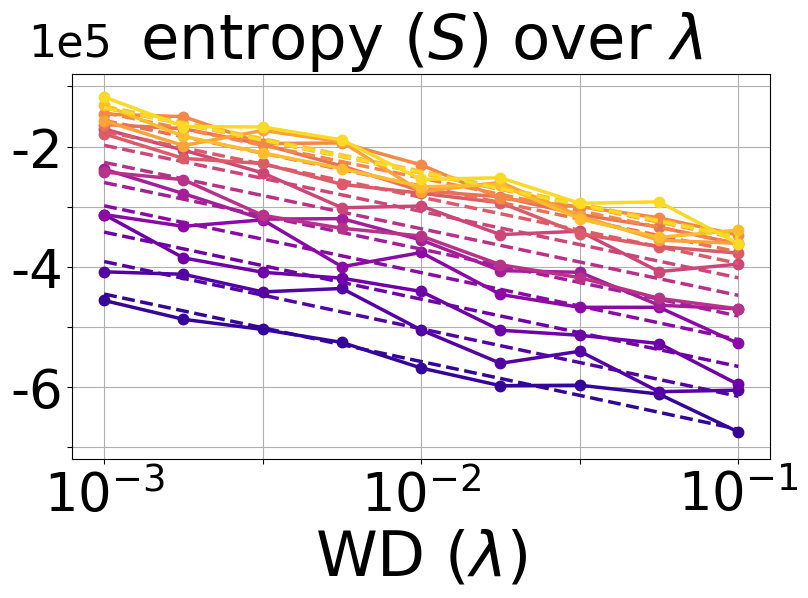

In [212]:
plt.figure(figsize=(9, 5))
plt.tight_layout()

for i in range(len(lrs)):
    plt.plot(wds, S_full[i], color=lr_colors[i], marker='.', linestyle='-', markersize=15, linewidth=2.5)
    plt.plot(wds, S_smoothed[i], color=lr_colors[i], linestyle='--', linewidth=2.5)

plt.plot([], [], linestyle='-', marker='.', color='gray', label=r'exp.', markersize=15, linewidth=2.5)
plt.plot([], [], color='gray', label='smooth', linestyle='--', linewidth=2.5)
plt.xscale('log')
#plt.yscale('log')
plt.xticks([1e-3, 10 ** -2.5, 1e-2, 10 ** -1.5, 10 ** -1], ['$10^{-3}$', '', '$10^{-2}$', '', '$10^{-1}$'], fontsize=38)
plt.xticks([], [], minor=True)
plt.yticks([-7e5, -6e5, -5e5, -4e5, -3e5, -2e5, -1e5], ['', '-6', '', '-4', '', '-2', ''], fontsize=38)
plt.annotate(xy=(10**-3.24, -0.5e5), text=r'1e5', fontsize=32, annotation_clip=False)
plt.yticks([], [], minor=True)
plt.ylim(-7.2e5, -0.8e5)
plt.xlabel(r'WD ($\lambda$)', fontsize=45)
plt.title(r'entropy ($S$) over $\lambda$', fontsize=45, y=1.02)
#plt.legend(ncol=1, fontsize=38, loc=(0.54, 0.04),
#           columnspacing=0.2, handletextpad=0.35, labelspacing=0.2, handlelength=0.95)
plt.grid()
plt.savefig(f'{IMAGE_DIR}ELR-entropy-WD.png', dpi=400, bbox_inches='tight')

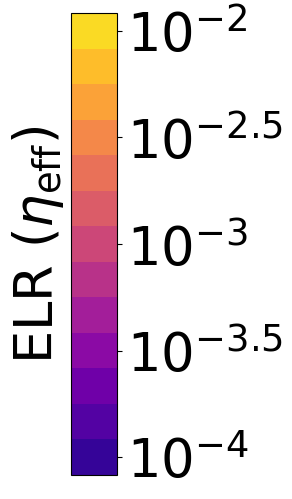

In [213]:
import matplotlib as mpl

cmap = mpl.colors.LinearSegmentedColormap.from_list("custom_plasma", lr_colors, N=len(lr_colors))
fig, ax = plt.subplots(figsize=(0.6, 6))
norm = mpl.colors.Normalize(vmin=0, vmax=len(lr_colors))
cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical')
cb.set_ticks([0.5, 3.5, 6.5, 9.5, 12.5])
cb.set_ticklabels(['$10^{-4}$', '$10^{-3.5}$', '$10^{-3}$', '$10^{-2.5}$', '$10^{-2}$'], fontsize=38)
cb.set_label('')
ax.text(-0.1, 0.5, r'ELR ($\eta_{\text{eff}}$)', fontsize=38, transform=ax.transAxes,
        rotation=90, va='center', ha='right')

plt.savefig(f'{IMAGE_DIR}ELR-legend1.png', dpi=400, bbox_inches='tight')

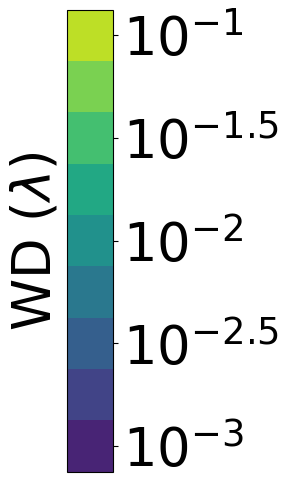

In [214]:
import matplotlib as mpl

cmap = mpl.colors.LinearSegmentedColormap.from_list("custom_plasma", wd_colors, N=len(wd_colors))
fig, ax = plt.subplots(figsize=(0.6, 6))
norm = mpl.colors.Normalize(vmin=0, vmax=len(wd_colors))
cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical')
cb.set_ticks([0.5, 2.5, 4.5, 6.5, 8.5])
cb.set_ticklabels(['$10^{-3}$', '$10^{-2.5}$', '$10^{-2}$', '$10^{-1.5}$', '$10^{-1}$'], fontsize=38)
cb.set_label('')
ax.text(-0.1, 0.5, r'WD ($\lambda$)', fontsize=38, transform=ax.transAxes,
        rotation=90, va='center', ha='right')

plt.savefig(f'{IMAGE_DIR}ELR-legend2.png', dpi=400, bbox_inches='tight')

In [223]:
dS_dlog_eta = coefs[1] + 2 * coefs[3] * np.log(lrs).reshape(-1, 1) + coefs[5] * np.log(wds).reshape(1, -1)
dS_dlog_p = coefs[2] + 2 * coefs[4] * np.log(wds).reshape(1, -1) + coefs[5] * np.log(lrs).reshape(-1, 1)
rel_errors = (dS_dlog_p + (D - 1) / 2) / (D - 1) * 2
np.abs(rel_errors).max()

0.03953827621042031

In [224]:
coefs[2] / (D - 1) * 2

-0.9301401096428896

In [225]:
2 * coefs[4] / (D - 1) * 2

-0.0014776260835193237

In [226]:
coefs[5] / (D - 1) * 2

0.00880069397843253

## Fixed LR

In [227]:
general_path = '../experiments/convnet16_cifar100_50000obj_ce/fixed_lr/'

dirs = os.listdir(general_path)
lrs, wds = [], []
for directory in dirs:
    with open(os.path.join(general_path, directory, 'config.json')) as f:
        config = json.load(f)
        lrs.append(config['lr'])
        wds.append(config['wd'])

lrs = np.unique(lrs)
wds = np.unique(wds)
#wds = np.logspace(-3, -1, 5)
wd_colors = sns.color_palette('viridis', len(wds))
lr_colors = sns.color_palette('plasma', len(lrs))

In [228]:
log_iters = np.array(config['log_iters'])
shape = (len(lrs), len(wds), len(log_iters))
train_losses = np.zeros(shape)
stoch_grad_rms = np.zeros(shape)
full_grad_norms = np.zeros(shape)
spherical_entropies = np.zeros(shape)
log_radii = np.zeros(shape)
mean_radii = np.zeros(shape)

for i, lr in enumerate(lrs):
    for j, wd in enumerate(wds):
        path = general_path+f'lr{lr:.2e}_wd{wd:.2e}_seed1/trace.pt'
        try:
            trace = torch.load(path, map_location=torch.device('cpu'), weights_only=False)
            train_losses[i, j] = np.array(trace['trace']['train_loss'])
            stoch_grad_rms[i, j] = np.array(trace['trace']['stoch_grad_rms'])
            full_grad_norms[i, j] = np.array(trace['trace']['full_grad_norm'])
            spherical_entropies[i, j] = np.array(trace['trace']['spherical_entropy'])
            log_radii[i, j] = np.array(trace['trace']['log_radius'])
            mean_radii[i, j] = np.array(trace['trace']['mean_radius'])
        except:
            print(f'No checkpoint for LR={lr:.2e}, WD={wd:.2e}')

full_entropies = spherical_entropies + log_radii
covariance_traces = stoch_grad_rms ** 2 * mean_radii ** 2
full_gn_sq = full_grad_norms ** 2 * mean_radii ** 2

In [229]:
D = 0
for key, param in trace['model'].items():
    if 'conv_layers' in key and 'weight' in key:
        D += param.numel()
D

97200

In [230]:
num_logs_to_avg = 60
U = train_losses[..., -num_logs_to_avg:].mean(-1)
S_sphere = spherical_entropies[..., -num_logs_to_avg:].mean(-1)
S_full = full_entropies[..., -num_logs_to_avg:].mean(-1)
r = mean_radii[..., -num_logs_to_avg:].mean(-1)
V = 0.5 * r ** 2
tr_Sigma = covariance_traces[..., -num_logs_to_avg:].mean(-1)
sigma_sq = tr_Sigma / (D - 1)
full_gn_sq = full_gn_sq[..., -num_logs_to_avg:].mean(-1)
T = np.sqrt(lrs.reshape(-1, 1) * wds.reshape(1, -1) * sigma_sq / 2 / (D - 1))

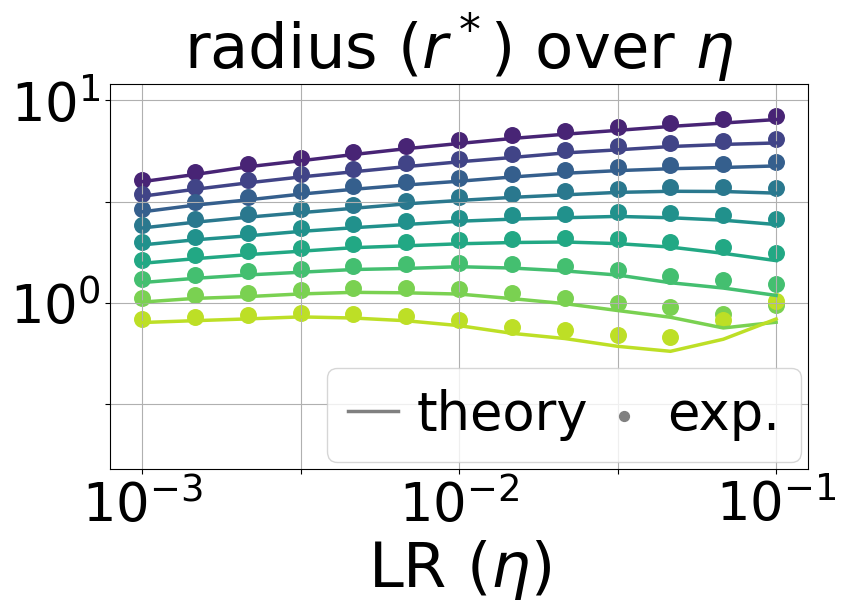

In [231]:
plt.figure(figsize=(9, 5))
plt.tight_layout()

for i in range(len(wds)):
    wd = wds[i]
    pred_rs = (T[:, i] * (D - 1) / wd) ** 0.5
    plt.scatter(lrs, r[:, i], color=wd_colors[i], marker='.', s=500)
    plt.plot(lrs, pred_rs, color=wd_colors[i], linestyle='-', linewidth=2.5)

plt.plot([], [], linestyle='-', color='gray', label=r'theory', linewidth=2.5)
plt.scatter([], [], color='gray', marker='.', label='exp.', s=200)
plt.xscale('log')
plt.yscale('log')
plt.xticks([1e-3, 10 ** -2.5, 1e-2, 10 ** -1.5, 1e-1], ['$10^{-3}$', '', '$10^{-2}$', '', '$10^{-1}$'], fontsize=38)
plt.xticks([], [], minor=True)
plt.yticks([10 ** -0.5, 1, 10 ** 0.5, 10], ['', '$10^{0}$', '', '$10^{1}$'], fontsize=38)
plt.yticks([], [], minor=True)
plt.ylim(1.5e-1, 12)
plt.xlabel(r'LR ($\eta$)', fontsize=45)
plt.title(r'radius ($r^*$) over $\eta$', fontsize=45, y=1.02)
plt.legend(ncol=2, fontsize=38, loc=(0.31, 0.02),
           columnspacing=0.2, handletextpad=0.35, labelspacing=0.2, handlelength=0.95)
plt.grid()
plt.savefig(f'{IMAGE_DIR}LR-radius.png', dpi=400, bbox_inches='tight')

<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:23: SyntaxWarning: invalid escape sequence '\l'
/var/folders/03/wmtcyjrj71bgyd6ps5fk0hdh0000gn/T/ipykernel_7471/2710006072.py:23: SyntaxWarning: invalid escape sequence '\l'
  leg = plt.legend(ncol=1, title='WD ($\lambda$)', fontsize=32, loc=(1.01, 0.05),


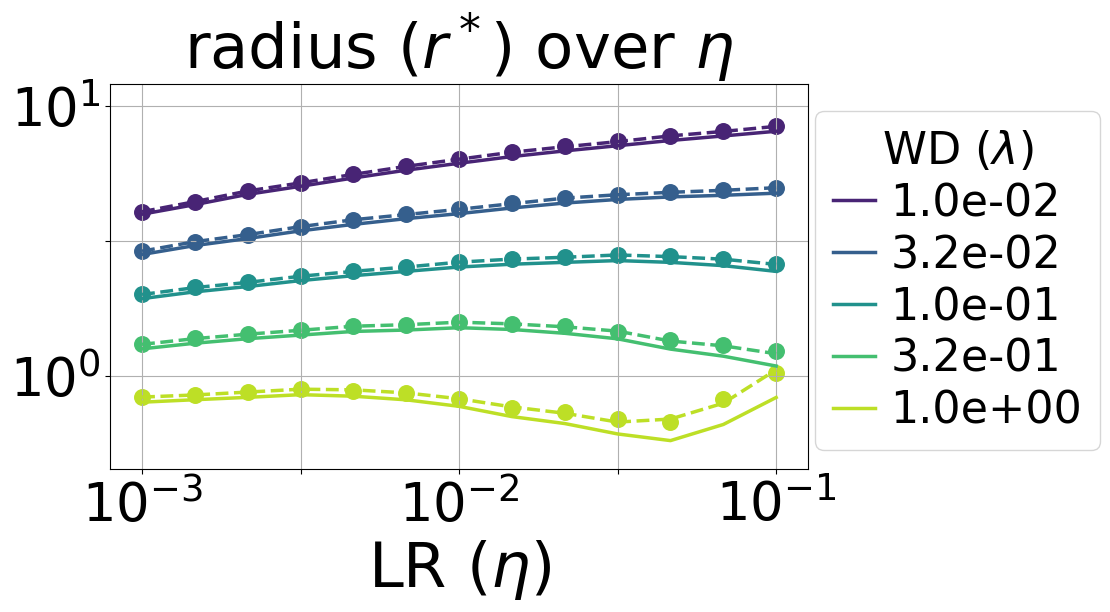

In [232]:
plt.figure(figsize=(9, 5))
plt.tight_layout()

for i in range(0, len(wds), 2):
    wd = wds[i]
    pred_rs = (T[:, i] * (D - 1) / wd) ** 0.5
    discr_pred_rs = (lrs * (tr_Sigma[:, i] + full_gn_sq[:, i]) / (2 * wd)) ** 0.25
    plt.scatter(lrs, r[:, i], color=wd_colors[i], marker='.', s=500)
    plt.plot(lrs, pred_rs, color=wd_colors[i], linestyle='-', linewidth=2.5, label=f'{wd:.1e}')
    plt.plot(lrs, discr_pred_rs, color=wd_colors[i], linestyle='--', linewidth=2.5)

#plt.plot([], [], linestyle='-', color='gray', label=r'theory', linewidth=2.5)
#plt.scatter([], [], color='gray', marker='.', label='exp.', s=200)
plt.xscale('log')
plt.yscale('log')
plt.xticks([1e-3, 10 ** -2.5, 1e-2, 10 ** -1.5, 1e-1], ['$10^{-3}$', '', '$10^{-2}$', '', '$10^{-1}$'], fontsize=38)
plt.xticks([], [], minor=True)
plt.yticks([10 ** -0.5, 1, 10 ** 0.5, 10], ['', '$10^{0}$', '', '$10^{1}$'], fontsize=38)
plt.yticks([], [], minor=True)
plt.ylim(4.5e-1, 12)
plt.xlabel(r'LR ($\eta$)', fontsize=45)
plt.title(r'radius ($r^*$) over $\eta$', fontsize=45, y=1.02)
leg = plt.legend(ncol=1, title='WD ($\lambda$)', fontsize=32, loc=(1.01, 0.05),
           columnspacing=0.2, handletextpad=0.35, labelspacing=0.2, handlelength=0.95)
plt.setp(leg.get_title(),fontsize=32)
plt.grid()
plt.savefig(f'{IMAGE_DIR}LR-discr-radius.png', dpi=400, bbox_inches='tight')

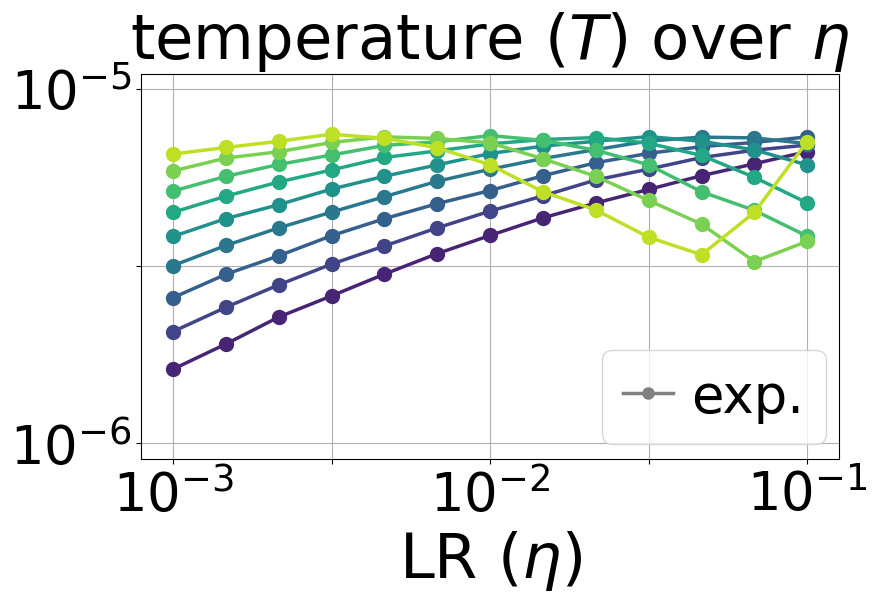

In [172]:
plt.figure(figsize=(9, 5))
plt.tight_layout()

for i in range(len(wds)):
    wd = wds[i]
    plt.plot(lrs, T[:, i], color=wd_colors[i], marker='o', markersize=10, linestyle='-', linewidth=2.5)

plt.plot([], [], linestyle='-', marker='o', markersize=8, color='gray', label=r'exp.', linewidth=2.5)
plt.xscale('log')
plt.yscale('log')
plt.xticks([1e-3, 10 ** -2.5, 1e-2, 10 ** -1.5, 1e-1], ['$10^{-3}$', '', '$10^{-2}$', '', '$10^{-1}$'], fontsize=38)
plt.xticks([], [], minor=True)
plt.yticks([10 ** -6.5, 10 ** -6, 10 ** -5.5, 10 ** -5], ['', '$10^{-6}$', '', '$10^{-5}$'], fontsize=38)
plt.yticks([], [], minor=True)
plt.ylim(9e-7, 1.1e-5)
plt.xlabel(r'LR ($\eta$)', fontsize=45)
plt.title(r'temperature ($T$) over $\eta$', fontsize=45, y=1.02)
plt.legend(ncol=2, fontsize=38, loc=(0.66, 0.04),
           columnspacing=0.2, handletextpad=0.35, labelspacing=0.2, handlelength=0.95)
plt.grid()
plt.savefig(f'{IMAGE_DIR}LR-temp.png', dpi=400, bbox_inches='tight')

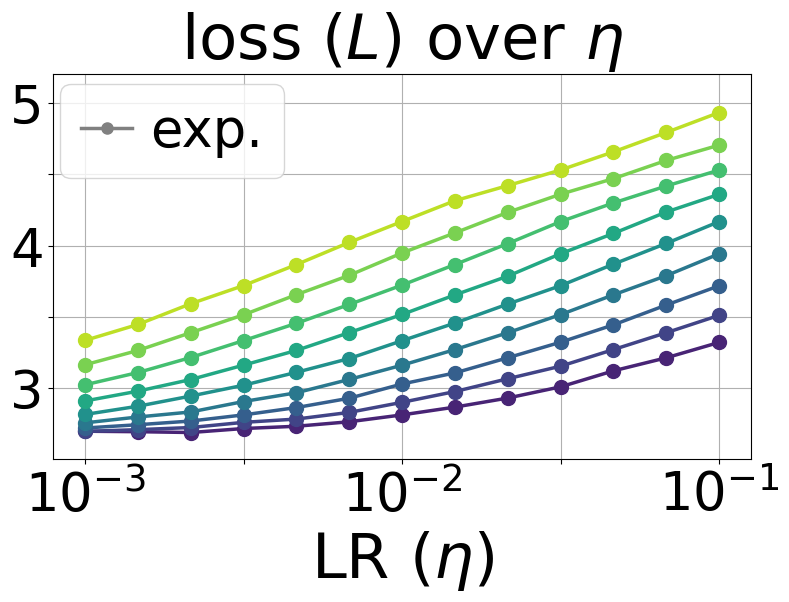

In [173]:
plt.figure(figsize=(9, 5))
plt.tight_layout()

for i in range(len(wds)):
    wd = wds[i]
    plt.plot(lrs, U[:, i], color=wd_colors[i], marker='o', markersize=10, linestyle='-', linewidth=2.5)

plt.plot([], [], linestyle='-', marker='o', markersize=8, color='gray', label=r'exp.', linewidth=2.5)
plt.xscale('log')
#plt.yscale('log')
plt.xticks([1e-3, 10 ** -2.5, 1e-2, 10 ** -1.5, 1e-1], ['$10^{-3}$', '', '$10^{-2}$', '', '$10^{-1}$'], fontsize=38)
plt.xticks([], [], minor=True)
plt.yticks([3, 3.5, 4, 4.5, 5], [3, '', 4, '', 5], fontsize=38)
plt.yticks([], [], minor=True)
plt.ylim(2.5, 5.2)
plt.xlabel(r'LR ($\eta$)', fontsize=45)
plt.title(r'loss ($L$) over $\eta$', fontsize=45, y=1.02)
plt.legend(ncol=2, fontsize=38, loc=(0.01, 0.73),
           columnspacing=0.2, handletextpad=0.35, labelspacing=0.2, handlelength=0.95)
plt.grid()
plt.savefig(f'{IMAGE_DIR}LR-loss.png', dpi=400, bbox_inches='tight')

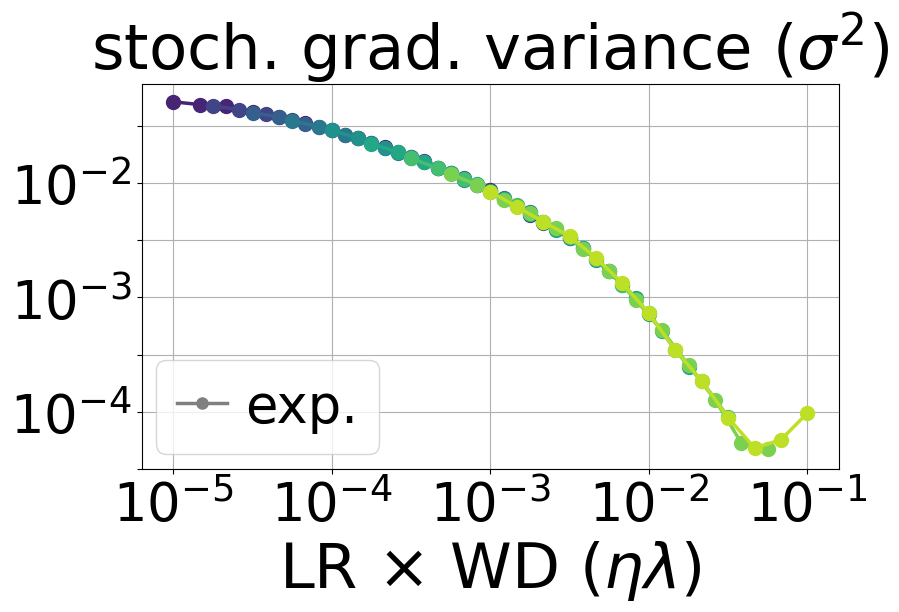

In [174]:
plt.figure(figsize=(9, 5))
plt.tight_layout()

for i in range(len(wds)):
    wd = wds[i]
    plt.plot(lrs * wd, sigma_sq[:, i], color=wd_colors[i], marker='o', markersize=10, linestyle='-', linewidth=2.5)

plt.plot([], [], linestyle='-', marker='o', markersize=8, color='gray', label=r'exp.', linewidth=2.5)
plt.xscale('log')
plt.yscale('log')
plt.xticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
           ['$10^{-5}$', '$10^{-4}$', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$'], fontsize=38)
plt.xticks([], [], minor=True)
plt.yticks([10 ** -4.5, 10 ** -4, 10 ** -3.5, 10 ** -3, 10 ** -2.5, 10 ** -2, 10 ** -1.5], ['', '$10^{-4}$', '', '$10^{-3}$', '', '$10^{-2}$', ''], fontsize=38)
plt.yticks([], [], minor=True)
#plt.ylim(4e-4, 8e-2)
plt.xlabel(r'LR $\times$ WD ($\eta \lambda$)', fontsize=45)
plt.title(r'stoch. grad. variance ($\sigma^2$)', fontsize=45, y=1.02)
plt.legend(ncol=2, fontsize=38, loc=(0.02, 0.04),
           columnspacing=0.2, handletextpad=0.35, labelspacing=0.2, handlelength=0.95)
plt.grid()
plt.savefig(f'{IMAGE_DIR}LR-sigma.png', dpi=400, bbox_inches='tight')

Maxwell relations for this case:
$$
\frac{\partial S}{\partial \log \eta} - \frac{\partial S}{\partial \log \lambda} = \frac{d-1}{2}
$$

Entropy is too noisy to check derivatives from the experimental data, so we approximate it using polynomial regression:
$$
S(\log \eta, \log \lambda) = a_0 + a_1\log\eta + a_2\log\lambda + a_3 \log^2\eta + a_4\log^2\lambda + a_5 \log\eta \log\lambda
$$

From the plots below we can see that the approximation with a first-degree polynomial is not sufficient (i.e., $\frac{\partial S}{\partial \log \eta}$ and $\frac{\partial S}{\partial \log \lambda}$ are not constants).

Here we have:
$$
\frac{\partial S}{\partial \log \eta}  = a_1 + 2 a_3 \log \eta + a_5 \log \lambda
$$
$$
\frac{\partial S}{\partial \log \lambda}  = a_2 + 2 a_4 \log \lambda + a_5 \log \eta
$$

In [235]:
log_lrs_ = np.tile(np.log(lrs).reshape(-1, 1), (1, len(wds))).reshape(-1)
log_wds_ = np.tile(np.log(wds).reshape(1, -1), (len(lrs), 1)).reshape(-1)
X = np.stack([
    log_lrs_, log_wds_, log_lrs_ ** 2, log_wds_ ** 2, log_lrs_ * log_wds_
], axis=1)

lin_regr = LinearRegression().fit(X, S_full.reshape(-1))
S_smoothed = lin_regr.predict(X).reshape(len(lrs), len(wds))
coefs = np.concatenate([np.array([lin_regr.intercept_]), lin_regr.coef_])
f'R^2 of approximation: {r2_score(S_full.reshape(-1), S_smoothed.reshape(-1)):.5f}'

'R^2 of approximation: 0.84117'

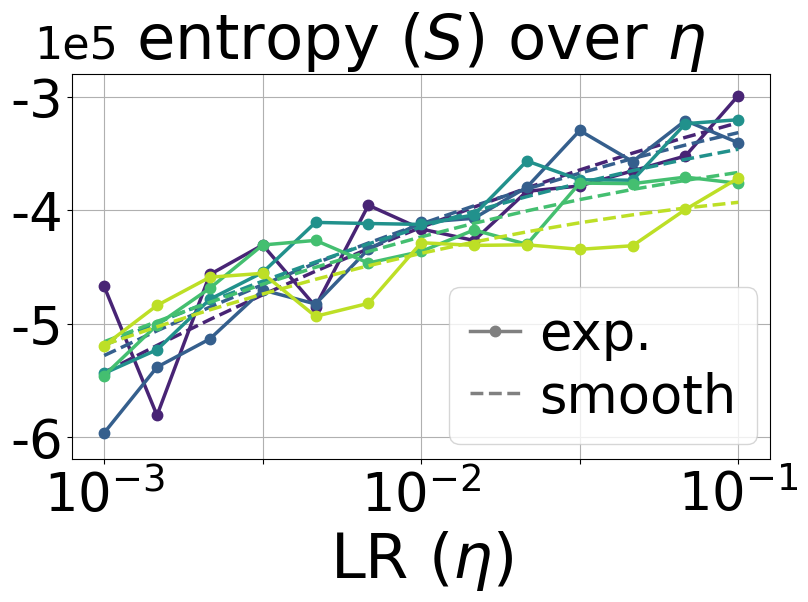

In [176]:
plt.figure(figsize=(9, 5))
plt.tight_layout()

for i in range(0, len(wds), 2):
    plt.plot(lrs, S_full[:, i], color=wd_colors[i], marker='.', markersize=15, linestyle='-', linewidth=2.5)
    plt.plot(lrs, S_smoothed[:, i], color=wd_colors[i], linestyle='--', linewidth=2.5)

plt.plot([], [], linestyle='-', marker='.', color='gray', label=r'exp.', markersize=15, linewidth=2.5)
plt.plot([], [], color='gray', label='smooth', linestyle='--', linewidth=2.5)
plt.xscale('log')
#plt.yscale('log')
plt.xticks([1e-3, 10 ** -2.5, 1e-2, 10 ** -1.5, 1e-1], ['$10^{-3}$', '', '$10^{-2}$', '', '$10^{-1}$'], fontsize=38)
plt.xticks([], [], minor=True)
plt.yticks([-6e5, -5e5, -4e5, -3e5], ['-6', '-5', '-4', '-3'], fontsize=38)
plt.annotate(xy=(10**-3.22, -2.65e5), text=r'1e5', fontsize=32, annotation_clip=False)
plt.yticks([], [], minor=True)
plt.ylim(-6.2e5, -2.8e5)
plt.xlabel(r'LR ($\eta$)', fontsize=45)
plt.title(r'entropy ($S$) over $\eta$', fontsize=45, y=1.02)
plt.legend(ncol=1, fontsize=38, loc=(0.54, 0.04),
           columnspacing=0.2, handletextpad=0.35, labelspacing=0.2, handlelength=0.95)
plt.grid()
plt.savefig(f'{IMAGE_DIR}LR-entropy-LR.png', dpi=400, bbox_inches='tight')

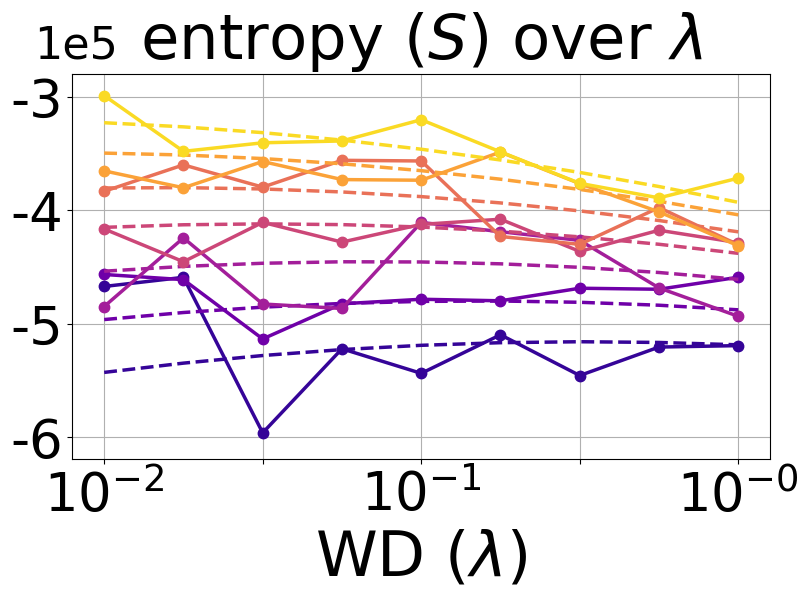

In [177]:
plt.figure(figsize=(9, 5))
plt.tight_layout()

for i in range(0, len(lrs), 2):
    plt.plot(wds, S_full[i], color=lr_colors[i], marker='.', linestyle='-', markersize=15, linewidth=2.5)
    plt.plot(wds, S_smoothed[i], color=lr_colors[i], linestyle='--', linewidth=2.5)

plt.plot([], [], linestyle='-', marker='.', color='gray', label=r'exp.', markersize=15, linewidth=2.5)
plt.plot([], [], color='gray', label='smooth', linestyle='--', linewidth=2.5)
plt.xscale('log')
#plt.yscale('log')
plt.xticks([1e-2, 10 ** -1.5, 1e-1, 10 ** -0.5, 10 ** 0], ['$10^{-2}$', '', '$10^{-1}$', '', '$10^{-0}$'], fontsize=38)
plt.xticks([], [], minor=True)
plt.yticks([-6e5, -5e5, -4e5, -3e5], ['-6', '-5', '-4', '-3'], fontsize=38)
plt.annotate(xy=(10**-2.22, -2.65e5), text=r'1e5', fontsize=32, annotation_clip=False)
plt.yticks([], [], minor=True)
plt.ylim(-6.2e5, -2.8e5)
plt.xlabel(r'WD ($\lambda$)', fontsize=45)
plt.title(r'entropy ($S$) over $\lambda$', fontsize=45, y=1.02)
#plt.legend(ncol=1, fontsize=38, loc=(0.54, 0.04),
#           columnspacing=0.2, handletextpad=0.35, labelspacing=0.2, handlelength=0.95)
plt.grid()
plt.savefig(f'{IMAGE_DIR}LR-entropy-WD.png', dpi=400, bbox_inches='tight')

In [236]:
dS_dlog_eta = coefs[1] + 2 * coefs[3] * np.log(lrs).reshape(-1, 1) + coefs[5] * np.log(wds).reshape(1, -1)
dS_dlog_p = coefs[2] + 2 * coefs[4] * np.log(wds).reshape(1, -1) + coefs[5] * np.log(lrs).reshape(-1, 1)
rel_errors = ((dS_dlog_eta - dS_dlog_p) - (D - 1) / 2) / (D - 1) * 2
np.abs(rel_errors).max()

0.23291957528107793

In [240]:
(coefs[1] - coefs[2]) / ((D - 1) / 2)

0.6593335601421537

In [241]:
(2 * coefs[3] - coefs[5]) / ((D - 1) / 2)

-0.04679386872806745

In [242]:
(2 * coefs[4] - coefs[5]) / ((D - 1) / 2)

0.0006526789721971824

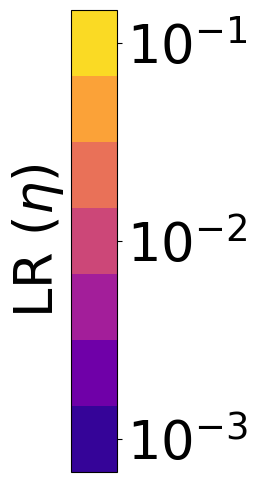

In [182]:
import matplotlib as mpl

cmap = mpl.colors.LinearSegmentedColormap.from_list("custom_plasma", lr_colors[::2], N=len(lr_colors[::2]))
fig, ax = plt.subplots(figsize=(0.6, 6))
norm = mpl.colors.Normalize(vmin=0, vmax=len(lr_colors[::2]))
cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical')
cb.set_ticks([0.5, 3.5, 6.5])
cb.set_ticklabels(['$10^{-3}$', '$10^{-2}$', '$10^{-1}$'], fontsize=38)
cb.set_label('')
ax.text(-0.1, 0.5, r'LR ($\eta$)', fontsize=38, transform=ax.transAxes,
        rotation=90, va='center', ha='right')

plt.savefig(f'{IMAGE_DIR}LR-legend1.png', dpi=400, bbox_inches='tight')

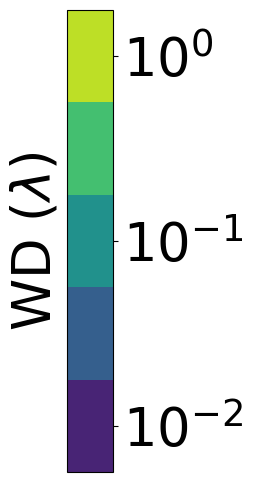

In [183]:
import matplotlib as mpl

cmap = mpl.colors.LinearSegmentedColormap.from_list("custom_plasma", wd_colors[::2], N=len(wd_colors[::2]))
fig, ax = plt.subplots(figsize=(0.6, 6))
norm = mpl.colors.Normalize(vmin=0, vmax=len(wd_colors[::2]))
cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical')
cb.set_ticks([0.5, 2.5, 4.5])
cb.set_ticklabels(['$10^{-2}$', '$10^{-1}$', '$10^{0}$'], fontsize=38)
cb.set_label('')
ax.text(-0.1, 0.5, r'WD ($\lambda$)', fontsize=38, transform=ax.transAxes,
        rotation=90, va='center', ha='right')

plt.savefig(f'{IMAGE_DIR}LR-legend2.png', dpi=400, bbox_inches='tight')

## Fixed sphere

In [ ]:
general_path = '../experiments/convnet16_cifar100_50000obj_ce/fixed_sphere/'

dirs = os.listdir(general_path)
lrs, rs = [], []
for directory in dirs:
    with open(os.path.join(general_path, directory, 'config.json')) as f:
        config = json.load(f)
        #if config['lr'] < 0.02:
        lrs.append(config['lr'])
        rs.append(config['si_pnorm_0'])

lrs = np.unique(lrs)
rs = np.unique(rs)
r_colors = sns.color_palette('viridis', len(rs))
lr_colors = sns.color_palette('plasma', len(lrs))

In [64]:
log_iters = np.array(config['log_iters'])
running_log_iters = np.arange(config['running_log_freq'], config['num_iters'] + 1, config['running_log_freq'])
shape = (len(lrs), len(rs), len(log_iters))
train_losses = np.zeros(shape)
stoch_grad_rms = np.zeros(shape)
full_grad_norms = np.zeros(shape)
spherical_entropies = np.zeros(shape)
log_radii = np.zeros(shape)
mean_radii = np.zeros(shape)
running_radii = np.zeros((len(lrs), len(rs), len(running_log_iters)))

for i, lr in enumerate(lrs):
    for j, r in enumerate(rs):
        path = general_path+f'lr{lr:.2e}_r{r:.2e}_seed1/trace.pt'
        trace = torch.load(path, map_location=torch.device('cpu'), weights_only=False)
        try:
            train_losses[i, j] = np.array(trace['trace']['train_loss'])
            stoch_grad_rms[i, j] = np.array(trace['trace']['stoch_grad_rms'])
            full_grad_norms[i, j] = np.array(trace['trace']['full_grad_norm'])
            spherical_entropies[i, j] = np.array(trace['trace']['spherical_entropy'])
            log_radii[i, j] = np.array(trace['trace']['log_radius'])
            mean_radii[i, j] = np.array(trace['trace']['mean_radius'])
            running_radii[i, j] = np.array(trace['trace']['running_radius'])
        except:
            print(f'No checkpoint for LR={lr:.2e}, r={r:.2e}')

full_entropies = spherical_entropies + log_radii
covariance_traces = stoch_grad_rms ** 2 * rs.reshape(1, -1, 1) ** 2
full_gn_sq = full_grad_norms ** 2 * rs.reshape(1, -1, 1) ** 2

In [65]:
num_logs_to_avg = 30
U = train_losses[..., -num_logs_to_avg:].mean(-1)
S_sphere = spherical_entropies[..., -num_logs_to_avg:].mean(-1)
S_full = full_entropies[..., -num_logs_to_avg:].mean(-1)
r = mean_radii[..., -num_logs_to_avg:].mean(-1)
V = 0.5 * r ** 2
tr_Sigma = covariance_traces[..., -num_logs_to_avg:].mean(-1)
full_gn_sq = full_gn_sq[..., -num_logs_to_avg:].mean(-1) 
sigma_sq = tr_Sigma / (D - 1)
T = lrs.reshape(-1, 1) * sigma_sq / 2
p = (running_radii[..., -100 * num_logs_to_avg:].mean(-1) - rs.reshape(1, -1)) / lrs.reshape(-1, 1) / rs.reshape(1, -1) ** 3

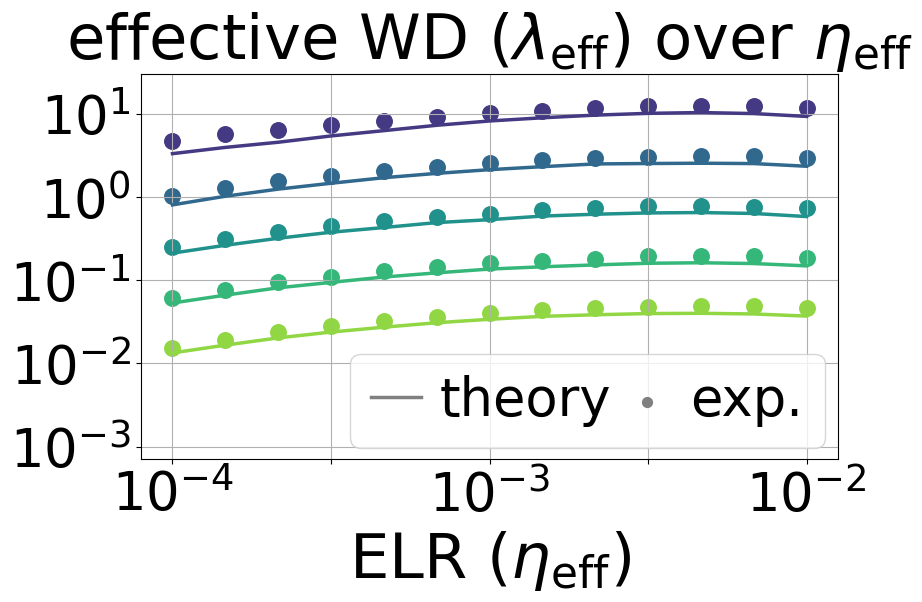

In [66]:
plt.figure(figsize=(9, 5))
plt.tight_layout()

for i in range(len(rs)):
    r = rs[i]
    pred_p = T[:, i] * (D - 1) / r ** 2
    plt.scatter(lrs, p[:, i], color=r_colors[i], marker='.', s=500)
    plt.plot(lrs, pred_p, color=r_colors[i], linestyle='-', linewidth=2.5)

plt.plot([], [], linestyle='-', color='gray', label=r'theory', linewidth=2.5)
plt.scatter([], [], color='gray', marker='.', label='exp.', s=200)
plt.xscale('log')
plt.yscale('log')
plt.xticks([1e-4, 10 ** -3.5, 1e-3, 10 ** -2.5, 1e-2], ['$10^{-4}$', '', '$10^{-3}$', '', '$10^{-2}$'], fontsize=38)
plt.xticks([], [], minor=True)
plt.yticks([1e-3, 1e-2, 1e-1, 1, 10], ['$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$10^{0}$', '$10^{1}$'], fontsize=38)
plt.yticks([], [], minor=True)
plt.ylim(0.7e-3, 30)
plt.xlabel(r'ELR ($\eta_{\text{eff}}$)', fontsize=45)
plt.title(r'effective WD ($\lambda_{\text{eff}}$) over $\eta_{\text{eff}}$', fontsize=45, y=1.02)
plt.legend(ncol=2, fontsize=38, loc=(0.3, 0.03),
           columnspacing=0.2, handletextpad=0.35, labelspacing=0.2, handlelength=0.95)
plt.grid()
plt.savefig(f'{IMAGE_DIR}sphere-pressure.png', dpi=400, bbox_inches='tight')

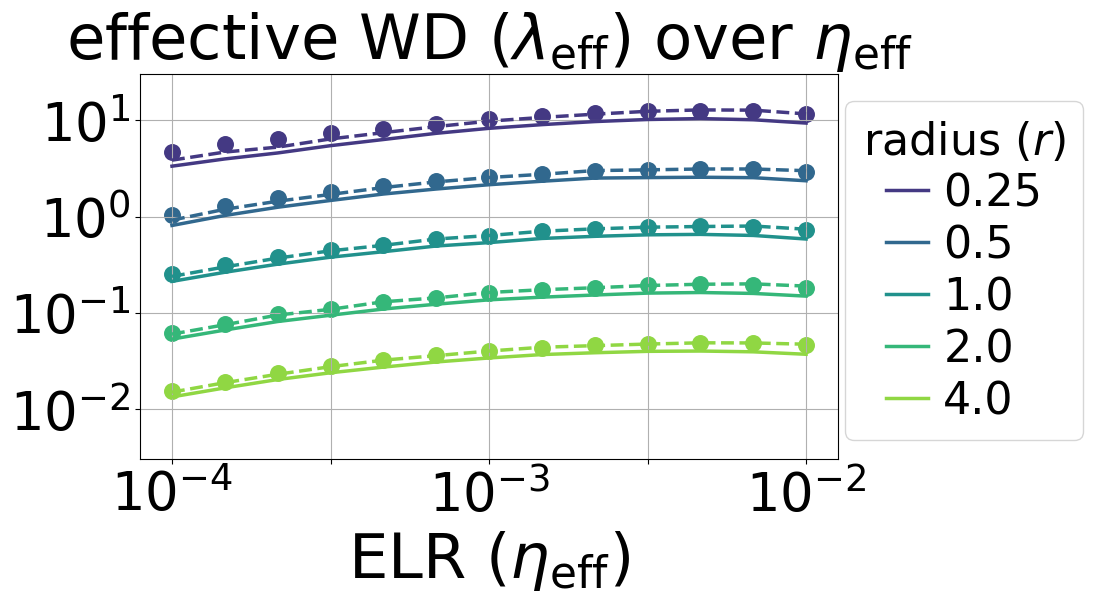

In [67]:
plt.figure(figsize=(9, 5))
plt.tight_layout()

for i in range(len(rs)):
    r = rs[i]
    pred_p = T[:, i] * (D - 1) / r ** 2
    discr_pred_p = lrs * (tr_Sigma[:, i] + full_gn_sq[:, i]) / (2 * r ** 2)
    plt.scatter(lrs, p[:, i], color=r_colors[i], marker='.', s=500)
    plt.plot(lrs, pred_p, color=r_colors[i], linestyle='-', linewidth=2.5, label=f'{r}')
    plt.plot(lrs, discr_pred_p, color=r_colors[i], linestyle='--', linewidth=2.5)

#plt.plot([], [], linestyle='-', color='gray', label=r'theory', linewidth=2.5)
#plt.scatter([], [], color='gray', marker='.', label='exp.', s=200)
plt.xscale('log')
plt.yscale('log')
plt.xticks([1e-4, 10 ** -3.5, 1e-3, 10 ** -2.5, 1e-2], ['$10^{-4}$', '', '$10^{-3}$', '', '$10^{-2}$'], fontsize=38)
plt.xticks([], [], minor=True)
plt.yticks([1e-3, 1e-2, 1e-1, 1, 10], ['$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$10^{0}$', '$10^{1}$'], fontsize=38)
plt.yticks([], [], minor=True)
plt.ylim(3e-3, 30)
plt.xlabel(r'ELR ($\eta_{\text{eff}}$)', fontsize=45)
plt.title(r'effective WD ($\lambda_{\text{eff}}$) over $\eta_{\text{eff}}$', fontsize=45, y=1.02)
leg = plt.legend(ncol=1, title='radius ($r$)', fontsize=32, loc=(1.01, 0.05),
           columnspacing=0.2, handletextpad=0.35, labelspacing=0.2, handlelength=0.95)
plt.setp(leg.get_title(),fontsize=32)
plt.grid()
plt.savefig(f'{IMAGE_DIR}sphere-discr-pressure.png', dpi=400, bbox_inches='tight')

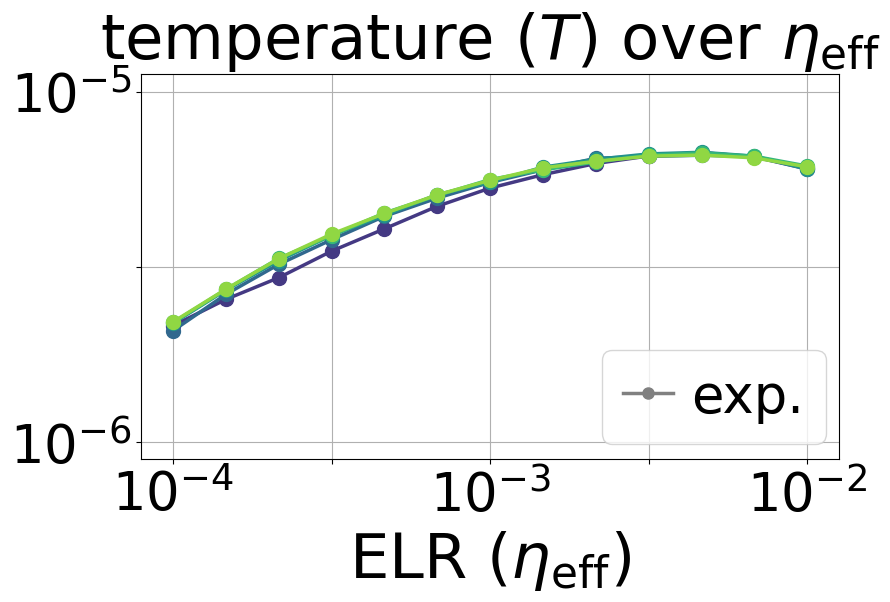

In [69]:
plt.figure(figsize=(9, 5))
plt.tight_layout()

for i in range(len(rs)):
    plt.plot(lrs, T[:, i], color=r_colors[i], marker='o', markersize=10, linestyle='-', linewidth=2.5)

plt.plot([], [], linestyle='-', marker='o', markersize=8, color='gray', label=r'exp.', linewidth=2.5)
plt.xscale('log')
plt.yscale('log')
plt.xticks([1e-4, 10 ** -3.5, 1e-3, 10 ** -2.5, 1e-2], ['$10^{-4}$', '', '$10^{-3}$', '', '$10^{-2}$'], fontsize=38)
plt.xticks([], [], minor=True)
plt.yticks([10 ** -6, 10 ** -5.5, 10 ** -5], ['$10^{-6}$', '', '$10^{-5}$'], fontsize=38)
plt.yticks([], [], minor=True)
plt.ylim(10 ** -6.05, 10 ** -4.95)
plt.xlabel(r'ELR ($\eta_{\text{eff}}$)', fontsize=45)
plt.title(r'temperature ($T$) over $\eta_{\text{eff}}$', fontsize=45, y=1.02)
plt.legend(ncol=2, fontsize=38, loc=(0.66, 0.04),
           columnspacing=0.2, handletextpad=0.35, labelspacing=0.2, handlelength=0.95)
plt.grid()
plt.savefig(f'{IMAGE_DIR}sphere-temp.png', dpi=400, bbox_inches='tight')

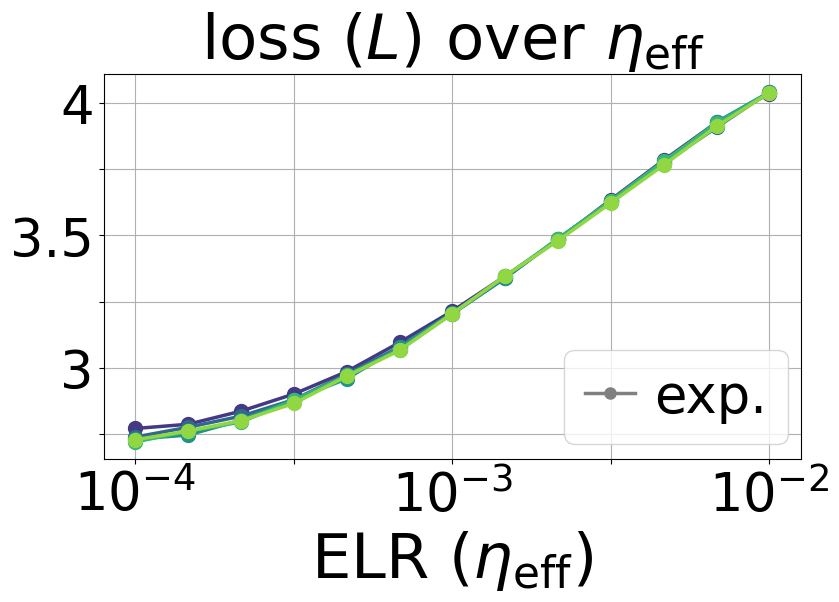

In [71]:
plt.figure(figsize=(9, 5))
plt.tight_layout()

for i in range(len(rs)):
    plt.plot(lrs, U[:, i], color=r_colors[i], marker='o', markersize=10, linestyle='-', linewidth=2.5)

plt.plot([], [], linestyle='-', marker='o', markersize=8, color='gray', label=r'exp.', linewidth=2.5)
plt.xscale('log')
#plt.yscale('log')
plt.xticks([1e-4, 10 ** -3.5, 1e-3, 10 ** -2.5, 1e-2], ['$10^{-4}$', '', '$10^{-3}$', '', '$10^{-2}$'], fontsize=38)
plt.xticks([], [], minor=True)
plt.yticks([2.75, 3, 3.25, 3.5, 3.75, 4], ['', 3, '', 3.5, '', 4], fontsize=38)
plt.yticks([], [], minor=True)
#plt.ylim(10 ** -0.55, 10 ** 0.3)
plt.xlabel(r'ELR ($\eta_{\text{eff}}$)', fontsize=45)
plt.title(r'loss ($L$) over $\eta_{\text{eff}}$', fontsize=45, y=1.02)
plt.legend(ncol=2, fontsize=38, loc=(0.66, 0.04),
           columnspacing=0.2, handletextpad=0.35, labelspacing=0.2, handlelength=0.95)
plt.grid()
plt.savefig(f'{IMAGE_DIR}sphere-loss.png', dpi=400, bbox_inches='tight')

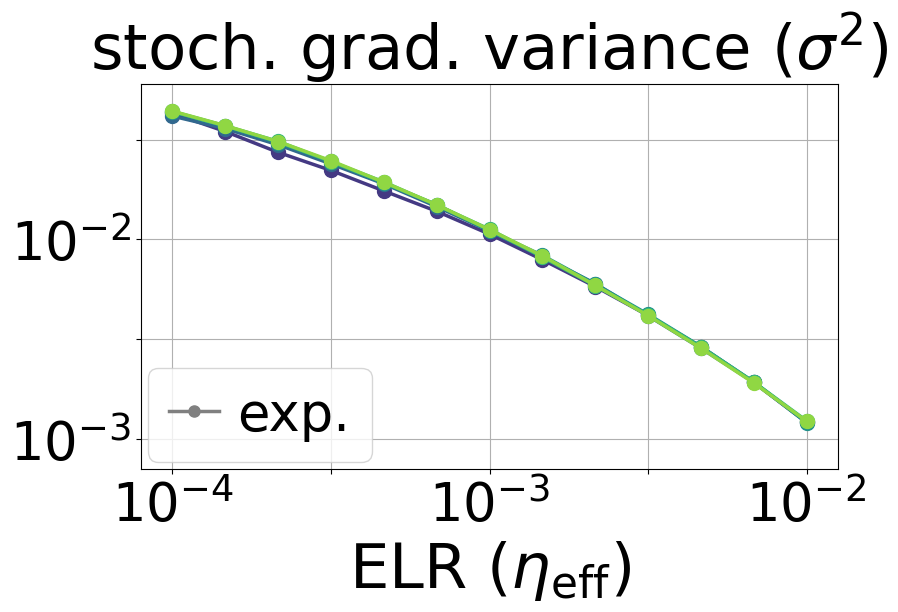

In [73]:
plt.figure(figsize=(9, 5))
plt.tight_layout()

for i in range(len(rs)):
    plt.plot(lrs, sigma_sq[:, i], color=r_colors[i], marker='o', markersize=10, linestyle='-', linewidth=2.5)

plt.plot([], [], linestyle='-', marker='o', markersize=8, color='gray', label=r'exp.', linewidth=2.5)
plt.xscale('log')
plt.yscale('log')
plt.xticks([1e-4, 10 ** -3.5, 1e-3, 10 ** -2.5, 1e-2], ['$10^{-4}$', '', '$10^{-3}$', '', '$10^{-2}$'], fontsize=38)
plt.xticks([], [], minor=True)
plt.yticks([10 ** -3, 10 ** -2.5, 10 ** -2, 10 ** -1.5], ['$10^{-3}$', '', '$10^{-2}$', ''], fontsize=38)
plt.yticks([], [], minor=True)
plt.ylim(7e-4, 6e-2)
plt.xlabel(r'ELR ($\eta_{\text{eff}}$)', fontsize=45)
plt.title(r'stoch. grad. variance ($\sigma^2$)', fontsize=45, y=1.02)
plt.legend(ncol=2, fontsize=38, loc=(0.01, 0.02),
           columnspacing=0.2, handletextpad=0.35, labelspacing=0.2, handlelength=0.95)

plt.grid()
plt.savefig(f'{IMAGE_DIR}sphere-sigma.png', dpi=400, bbox_inches='tight')

In [74]:
log_lrs_ = np.tile(np.log(lrs).reshape(-1, 1), (1, len(rs))).reshape(-1)
log_rs_ = np.tile(np.log(rs).reshape(1, -1), (len(lrs), 1)).reshape(-1)
X = np.stack([
    log_lrs_, log_rs_, log_lrs_ ** 2, log_rs_ ** 2, log_lrs_ * log_rs_
], axis=1)

lin_regr = LinearRegression().fit(X, S_full.reshape(-1))
S_smoothed = lin_regr.predict(X).reshape(len(lrs), len(rs))
coefs = np.concatenate([np.array([lin_regr.intercept_]), lin_regr.coef_])
f'R^2 of approximation: {r2_score(S_full.reshape(-1), S_smoothed.reshape(-1)):.5f}'

'R^2 of approximation: 0.94096'

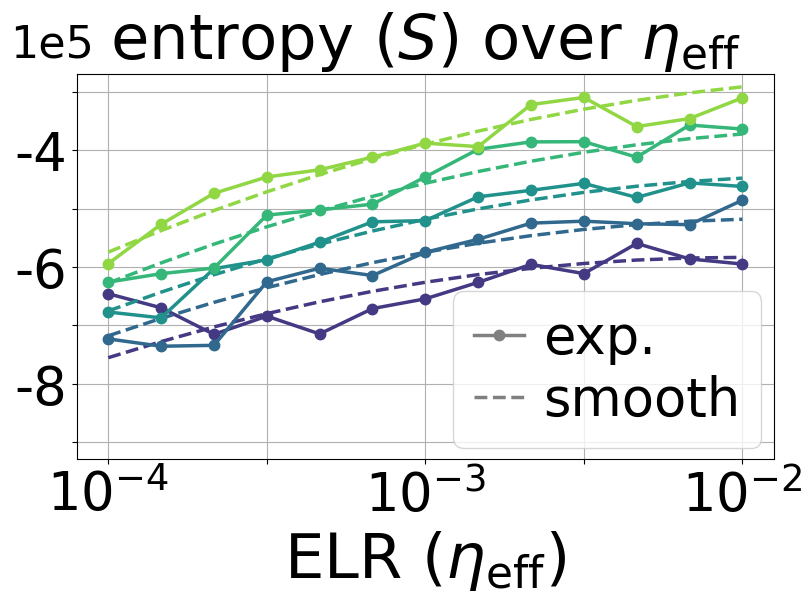

In [89]:
plt.figure(figsize=(9, 5))
plt.tight_layout()

for i in range(len(rs)):
    plt.plot(lrs, S_full[:, i], color=r_colors[i], marker='.', markersize=15, linestyle='-', linewidth=2.5)
    plt.plot(lrs, S_smoothed[:, i], color=r_colors[i], linestyle='--', linewidth=2.5)

plt.plot([], [], linestyle='-', marker='.', color='gray', label=r'exp.', markersize=15, linewidth=2.5)
plt.plot([], [], color='gray', label='smooth', linestyle='--', linewidth=2.5)
plt.xscale('log')
#plt.yscale('log')
plt.xticks([1e-4, 10 ** -3.5, 1e-3, 10 ** -2.5, 1e-2], ['$10^{-4}$', '', '$10^{-3}$', '', '$10^{-2}$'], fontsize=38)
plt.xticks([], [], minor=True)
plt.yticks([-9e5, -8e5, -7e5, -6e5, -5e5, -4e5, -3e5], ['', '-8', '', '-6', '', '-4', ''], fontsize=38)
plt.annotate(xy=(10**-4.31, -2.4e5), text=r'1e5', fontsize=32, annotation_clip=False)
plt.yticks([], [], minor=True)
plt.ylim(-9.3e5, -2.7e5)
plt.xlabel(r'ELR ($\eta_{\text{eff}}$)', fontsize=45)
plt.title(r'entropy ($S$) over $\eta_{\text{eff}}$', fontsize=45, y=1.02)
plt.legend(ncol=1, fontsize=38, loc=(0.54, 0.03),
           columnspacing=0.2, handletextpad=0.35, labelspacing=0.2, handlelength=0.95)
plt.grid()
plt.savefig(f'{IMAGE_DIR}sphere-entropy-LR.png', dpi=400, bbox_inches='tight')

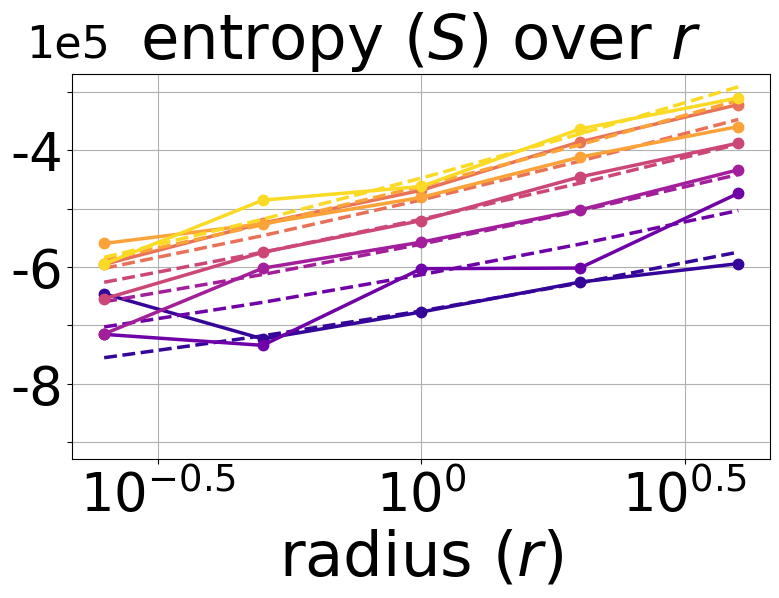

In [91]:
plt.figure(figsize=(9, 5))
plt.tight_layout()

for i in range(0, len(lrs), 2):
    plt.plot(rs, S_full[i], color=lr_colors[i], marker='.', linestyle='-', markersize=15, linewidth=2.5)
    plt.plot(rs, S_smoothed[i], color=lr_colors[i], linestyle='--', linewidth=2.5)

plt.plot([], [], linestyle='-', marker='.', color='gray', label=r'exp.', markersize=15, linewidth=2.5)
plt.plot([], [], color='gray', label='smooth', linestyle='--', linewidth=2.5)
plt.xscale('log')
#plt.yscale('log')
plt.xticks([10 ** -0.5, 1e-0, 10 ** 0.5], ['$10^{-0.5}$', '$10^{0}$', '$10^{0.5}$'], fontsize=38)
plt.xticks([], [], minor=True)
plt.yticks([-9e5, -8e5, -7e5, -6e5, -5e5, -4e5, -3e5], ['', '-8', '', '-6', '', '-4', ''], fontsize=38)
plt.annotate(xy=(10**-0.75, -2.4e5), text=r'1e5', fontsize=32, annotation_clip=False)
plt.yticks([], [], minor=True)
plt.ylim(-9.3e5, -2.7e5)
plt.xlabel(r'radius ($r$)', fontsize=45)
plt.title(r'entropy ($S$) over $r$', fontsize=45, y=1.02)
#plt.legend(ncol=1, fontsize=38, loc=(0.54, 0.04),
#           columnspacing=0.2, handletextpad=0.35, labelspacing=0.2, handlelength=0.95)
plt.grid()
plt.savefig(f'{IMAGE_DIR}sphere-entropy-radius.png', dpi=400, bbox_inches='tight')

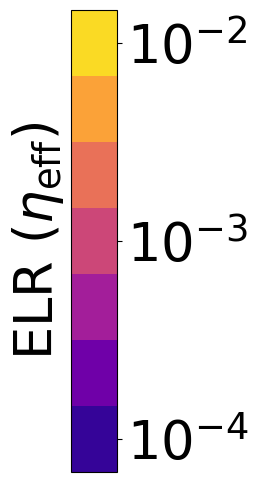

In [92]:
import matplotlib as mpl

cmap = mpl.colors.LinearSegmentedColormap.from_list("custom_plasma", lr_colors[::2], N=len(lr_colors[::2]))
fig, ax = plt.subplots(figsize=(0.6, 6))
norm = mpl.colors.Normalize(vmin=0, vmax=len(lr_colors[::2]))
cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical')
cb.set_ticks([0.5, 3.5, 6.5])
cb.set_ticklabels(['$10^{-4}$', '$10^{-3}$', '$10^{-2}$'], fontsize=38)
cb.set_label('')
ax.text(-0.1, 0.5, r'ELR ($\eta_{\text{eff}}$)', fontsize=38, transform=ax.transAxes,
        rotation=90, va='center', ha='right')

plt.savefig(f'{IMAGE_DIR}sphere-legend1.png', dpi=400, bbox_inches='tight')

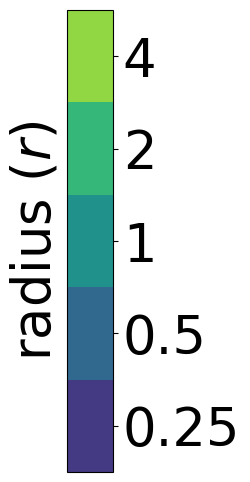

In [93]:
import matplotlib as mpl

cmap = mpl.colors.LinearSegmentedColormap.from_list("custom_plasma", r_colors, N=len(r_colors))
fig, ax = plt.subplots(figsize=(0.6, 6))
norm = mpl.colors.Normalize(vmin=0, vmax=len(r_colors))
cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical')
cb.set_ticks([0.5, 1.5, 2.5, 3.5, 4.5])
cb.set_ticklabels(['0.25', '0.5', '1', '2', '4'], fontsize=38)
cb.set_label('')
ax.text(-0.1, 0.5, r'radius ($r$)', fontsize=38, transform=ax.transAxes,
        rotation=90, va='center', ha='right')

plt.savefig(f'{IMAGE_DIR}sphere-legend2.png', dpi=400, bbox_inches='tight')